# Analysis of SoS Addresses

In [117]:
import csv
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import re 
from sklearn.decomposition import PCA
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

%xmode Minimal

Exception reporting mode: Minimal


In [27]:
# read in data 
sos = pd.read_csv('sos_df_23.csv')

In [28]:
# explore data
sos.info()
sos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   state     50 non-null     object
 1   gov_name  50 non-null     object
 2   party     50 non-null     object
 3   type      50 non-null     object
 4   text      50 non-null     object
dtypes: object(5)
memory usage: 2.1+ KB


,state,gov_name,party,type,text
0,alabama,kay ivey,republican,sos,Page 1 of 8 2023 STATE OF THE STATE ADDRES...
1,alaska,mike dunleavy,republican,sos,Governor Dunleavy’s 2023 State of the State Ad...
2,arizona,katie hobbs,democratic,sos,"Good afternoon, Chief Justice Brutinel, Secret..."
3,arkansas,sarah huckabee sanders,republican,inaug,"LITTLE ROCK, Ark.— Today, Governor Sarah Hucka..."
4,california,gavin newsom,democratic,inaug,Watch Governor Newsom’s swearing-in and inaugu...


## Explore full sos

In [29]:
# add word count columm
sos['word_count'] = [len(i.split()) for i in sos.text]

In [30]:
# check that this worked
sos 

,state,gov_name,party,type,text,word_count
0,alabama,kay ivey,republican,sos,Page 1 of 8 2023 STATE OF THE STATE ADDRES...,2980
1,alaska,mike dunleavy,republican,sos,Governor Dunleavy’s 2023 State of the State Ad...,6469
2,arizona,katie hobbs,democratic,sos,"Good afternoon, Chief Justice Brutinel, Secret...",4882
3,arkansas,sarah huckabee sanders,republican,inaug,"LITTLE ROCK, Ark.— Today, Governor Sarah Hucka...",2250
4,california,gavin newsom,democratic,inaug,Watch Governor Newsom’s swearing-in and inaugu...,2456
5,colorado,jared polis,democratic,sos,ForMedia-2023-StateOfState-GovernorPolis-AsPre...,7859
6,connecticut,ned lamont,democratic,sos,\r\n01/03/2023 2023 State of the ...,1878
7,delaware,john carney,democratic,sos,"January 19, 2023 As prepared for delivery #DE...",4157
8,florida,ron desantis,republican,sos,"From the Space Coast to the Suncoast, from St....",1658
9,georgia,brian kemp,republican,sos,"Lt. Governor Jones, Speaker Burns, President P...",3315


#### Examine distribution of word count and outiers

In [31]:
sos.word_count.describe()

count       50.000000
mean      5142.080000
std       5214.130263
min        531.000000
25%       3286.250000
50%       4251.500000
75%       4970.500000
max      36640.000000
Name: word_count, dtype: float64

(array([ 1.,  3.,  2., 11.,  5., 13.,  4.,  4.,  3.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  531.  ,  1253.18,  1975.36,  2697.54,  3419.72,  4141.9 ,
         4864.08,  5586.26,  6308.44,  7030.62,  7752.8 ,  8474.98,
         9197.16,  9919.34, 10641.52, 11363.7 , 12085.88, 12808.06,
        13530.24, 14252.42, 14974.6 , 15696.78, 16418.96, 17141.14,
        17863.32, 18585.5 , 19307.68, 20029.86, 20752.04, 21474.22,
        22196.4 , 22918.58, 23640.76, 24362.94, 25085.12, 25807.3 ,
        26529.48, 27251.66, 27973.84, 28696.02, 29418.2 , 30140.38,
        30862.56, 31584.74, 32306.92, 33029.1 , 33751.28, 34473.46,
        35195.64, 35917.82, 36640.  ]),
 <BarContainer object of 50 artists>)

Text(6000, 4, 'Mean length: 5142 words')

Text(6000, 7, 'Median length: 4251 words')

Text(0.5, 1.0, 'From 50 State of the State Addresses for 2023')

Text(0.5, 0.98, 'Distribution of Document Length - SOS')

Text(0.5, 0, 'Document Word Count')

Text(0, 0.5, 'Number of Documents')

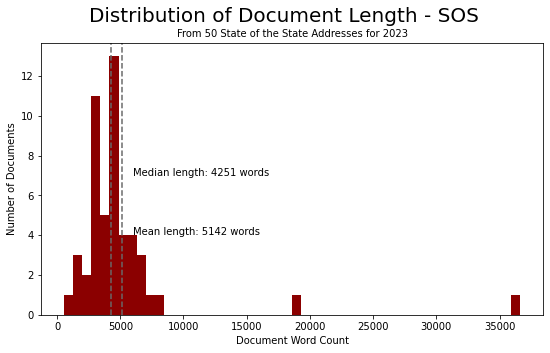

In [32]:
fig, ax = plt.subplots(figsize=(9,5))
ax.hist(sos.word_count, bins = 50, color = 'darkred')
ax.text(6000, 4, 'Mean length: 5142 words')
plt.axvline(x = 5142, color = 'dimgrey',ls = 'dashed')
ax.text(6000, 7, 'Median length: 4251 words')
plt.axvline(x = 4251, color = 'dimgrey',ls = 'dashed')
plt.title('From 50 State of the State Addresses for 2023', size = 10)
plt.suptitle('Distribution of Document Length - SOS', size = 20)
plt.xlabel('Document Word Count')
plt.ylabel('Number of Documents')
# fig.savefig('pompeo2020_hist.png')

In [33]:
# check the outliers
outliers = sos[sos.word_count > 15000].reset_index(drop = True)
outliers

,state,gov_name,party,type,text,word_count
0,illinois,jb pritzker,democratic,sos,"Gov. Pritzker Proposes Transformative, Gener...",18781
1,west virginia,jim justice,republican,sos,VIEW PHOTO ALBUM ...,36640


In [34]:
# duplicates 
# looks like text is repeated so let's clean
# outliers.text[0]

In [35]:
# test cleaning method
pattern = r'God bless the great state of Illinois'
input_string = outliers.text[0]
match = re.search(pattern, input_string)
clean_string = input_string[:match.end()]

# clean_string

In [36]:
# same issue 
# outliers.text[1]

In [37]:
# test cleaning method for second example
pattern2 = r'Thank you so much for having me. And God bless all of you.'

input_string2 = outliers.text[1]

match2 = re.search(pattern2, input_string2)

clean_string2 = input_string2[:match2.end()]

# clean_string2 

In [38]:
# do in main df 
def replace_text(state, pattern):
    input_string = sos.loc[sos.state == state, 'text'].values[0]
    match = re.search(pattern, input_string)
    clean_string = input_string[:match.end()]
    sos.loc[sos.state == state, 'text'] = clean_string
    return f'successfully added cleaned text for {state}'

In [39]:
replace_text('illinois', r'God bless the great state of Illinois')

'successfully added cleaned text for illinois'

In [40]:
replace_text('west virginia', r'Thank you so much for having me. And God bless all of you.')

'successfully added cleaned text for west virginia'

In [41]:
# redo word count 
sos['new_word_count'] = [len(i.split()) for i in sos.text]

In [42]:
sos.word_count.describe()
sos.new_word_count.describe() 

count       50.000000
mean      5142.080000
std       5214.130263
min        531.000000
25%       3286.250000
50%       4251.500000
75%       4970.500000
max      36640.000000
Name: word_count, dtype: float64

count      50.000000
mean     4342.600000
std      1687.350005
min       531.000000
25%      3286.250000
50%      4251.500000
75%      4970.500000
max      9157.000000
Name: new_word_count, dtype: float64

(array([ 1.,  1.,  3.,  2., 10.,  2., 11.,  8.,  2.,  3.,  4.,  0.,  2.,
         0.,  1.]),
 array([ 531.        , 1106.06666667, 1681.13333333, 2256.2       ,
        2831.26666667, 3406.33333333, 3981.4       , 4556.46666667,
        5131.53333333, 5706.6       , 6281.66666667, 6856.73333333,
        7431.8       , 8006.86666667, 8581.93333333, 9157.        ]),
 <BarContainer object of 15 artists>)

Text(6000, 6, 'Mean length: 4342 words')

Text(0.5, 1.0, 'From 50 State of the State Addresses for 2023')

Text(0.5, 0.98, 'Distribution of Document Length - SOS')

Text(0.5, 0, 'Document Word Count')

Text(0, 0.5, 'Number of Documents')

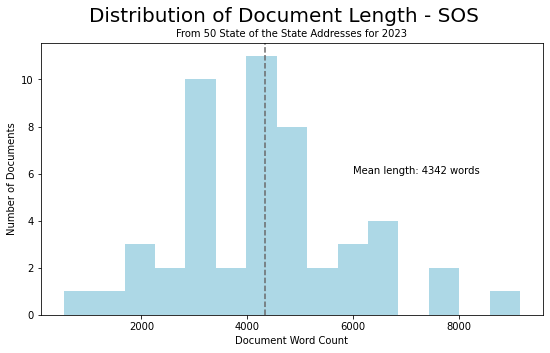

In [43]:
fig, ax = plt.subplots(figsize=(9,5))
ax.hist(sos.new_word_count, bins = 15, color = 'lightblue')
ax.text(6000, 6, 'Mean length: 4342 words')
plt.axvline(x = 4342, color = 'dimgrey',ls = 'dashed')
plt.title('From 50 State of the State Addresses for 2023', size = 10)
plt.suptitle('Distribution of Document Length - SOS', size = 20)
plt.xlabel('Document Word Count')
plt.ylabel('Number of Documents') 
# fig.savefig('pompeo2020_hist.png')

#### Min doc frequency 

In [82]:
# explore min_doc frequency options of 1-30
term_count = []

for i in range(1, 31):
    vectorizer = CountVectorizer(stop_words='english', min_df=i)
    dtm = vectorizer.fit_transform(sos.text)
    length = dtm.shape[1]
    term_count.append(length)

min_df = pd.DataFrame(data = {'Min Doc': range(1,31),
                              'Term Count': term_count})

Text(0.5, 1.0, 'From 50 State of the State Addresses in 2023')

Text(0.5, 0.98, 'Minimum Document Frequency and Resulting Term Count')

Text(0, 0.5, 'Term Count')

Text(0.5, 0, 'Minimum Document Frequency')

([<matplotlib.axis.XTick at 0x7fc481288e50>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30')])

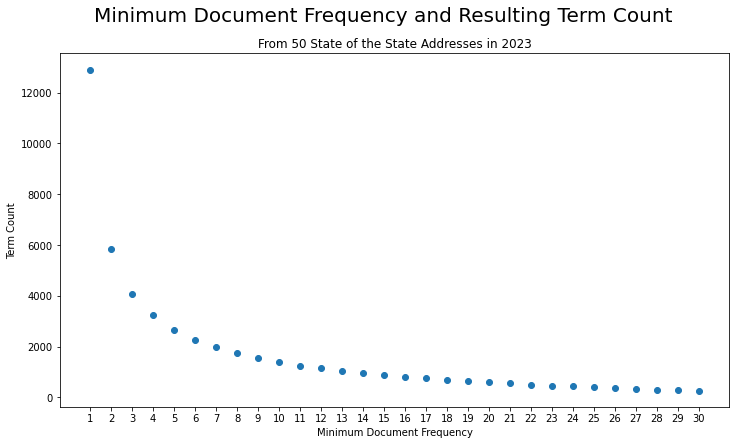

In [83]:
fig, ax = plt.subplots(figsize=(12,6.5))
# ax.plot(range(1,26), min_df['Term Count'], linewidth = 2.5, color = 'green')
ax.scatter(x = min_df['Min Doc'], y = min_df['Term Count'])
plt.title('From 50 State of the State Addresses in 2023')
plt.suptitle('Minimum Document Frequency and Resulting Term Count', size = 20)
plt.ylabel('Term Count')
plt.xlabel('Minimum Document Frequency')
plt.xticks(range(1,31))
#plt.savefig('min_doc_freq.png')

In [88]:
# Let's use 6 to reduce the words but still keep a high term count. Plus our overall sample size (50) is low.

#### + custom stopwords

In [89]:
# define functions for testing hyper parameter easily
def convert_to_term_df(dtm_input, tfidf_vectorizer_input):
    content_index = pd.DataFrame(dtm_input.toarray()).head()
    term_indices = {index: term for term, index in tfidf_vectorizer_input.vocabulary_.items()}
    colterms = [term_indices[i] for i in range(dtm_input.shape[1])]
    final_df = pd.DataFrame(dtm_input.toarray(), columns=colterms)

    return final_df

In [90]:
# https://stackoverflow.com/questions/34232190/scikit-learn-tfidfvectorizer-how-to-get-top-n-terms-with-highest-tf-idf-score
def get_top_terms(dtm_input, tfidf_vectorizer_input, num):
    importance = np.argsort(np.asarray(dtm_input.sum(axis=0)).ravel())[::-1]
    tfidf_feature_names = np.array(tfidf_vectorizer_input.get_feature_names_out())
    return tfidf_feature_names[importance[: num]]

In [91]:
# vectorize with stop words only 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=6)
dtm = tfidf_vectorizer.fit_transform(sos.text)
dtm.shape #(50, 2265)

(50, 2265)

In [93]:
# create df
df = convert_to_term_df(dtm, tfidf_vectorizer)
df.head()

,000,10,100,11,12,120,13,14,15,150,...,years,yes,yesterday,york,young,youngest,youth,zero,zip,zoning
0,0.011396,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,...,0.060761,0.000000,0.0,0.0,0.041006,0.027155,0.0,0.00000,0.027155,0.000000
1,0.006169,0.013914,0.015430,0.010683,0.017588,0.0,0.03586,0.011953,0.009656,0.000000,...,0.169932,0.024648,0.0,0.0,0.022197,0.000000,0.0,0.01362,0.000000,0.000000
2,0.030822,0.017380,0.009637,0.000000,0.032953,0.0,0.00000,0.000000,0.012061,0.013707,...,0.061624,0.000000,0.0,0.0,0.009242,0.000000,0.0,0.00000,0.000000,0.000000
3,0.015949,0.000000,0.000000,0.027620,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,...,0.085037,0.000000,0.0,0.0,0.019130,0.076009,0.0,0.00000,0.038004,0.000000
4,0.011349,0.012799,0.014194,0.019654,0.000000,0.0,0.00000,0.000000,0.000000,0.020189,...,0.080681,0.045348,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.028208


In [134]:
# add custom stop words - (tweaked throughout the process based on later parts of this notebook)
# https://aparnamishra144.medium.com/how-to-add-custom-stopwords-and-remove-them-from-text-in-nlp-50d342cfafff

stop_list = ['four','absolutely','tonight','state', 'governor', 'year', 'alabama', 'new', 'north', 'south', 'west', 'alaska', 'arizona', 'arkansas', 'california', 'colorado',
             'connecticut','delaware','florida','georgia','hawaii','idaho','illinois','indiana','iowa',
             'kansas','kentucky','louisiana','maine','maryland','massachusetts','michigan','minnesota',
             'mississippi','missouri','montana','nebraska','nevada', 'hampshire', 'jersey', 'mexico','york',
             'carolina', 'dakota','ohio','oklahoma','oregon','pennsylvania','rhode','island','tennessee','texas',
             'utah','vermont','virginia','washington','west virginia', 'wisconsin','wyoming', 
             'could', 'doe', 'ha', 'kansa', 'might', 'must', 'need', 'sha', 'wa', 'would']

stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(stop_list)
#stpwrd

In [94]:
# vectorize with custom stop words only 
tfidf_vectorizer1 = TfidfVectorizer(stop_words=stpwrd, min_df=6)
dtm1 = tfidf_vectorizer1.fit_transform(sos.text)
dtm1.shape # (50, 2347)

(50, 2347)

In [97]:
# get frequent terms 
get_top_terms(dtm1, tfidf_vectorizer1, 10)

# create df
df1 = convert_to_term_df(dtm1, tfidf_vectorizer1)
df1.head()

array(['people', 'us', 'years', 'one', 'every', 'work', 'make', 'also',
       'first', 'today'], dtype=object)

,000,10,100,11,12,120,13,14,15,150,...,years,yes,yesterday,yet,young,youngest,youth,zero,zip,zoning
0,0.011365,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.060593,0.000000,0.0,0.000000,0.040893,0.027080,0.0,0.000000,0.027080,0.000000
1,0.006811,0.015362,0.017037,0.011795,0.019418,0.0,0.039593,0.013198,0.010661,0.000000,...,0.187621,0.027214,0.0,0.000000,0.024507,0.000000,0.0,0.015038,0.000000,0.000000
2,0.031461,0.017740,0.009837,0.000000,0.033636,0.0,0.000000,0.000000,0.012311,0.013991,...,0.062902,0.000000,0.0,0.000000,0.009434,0.000000,0.0,0.000000,0.000000,0.000000
3,0.015460,0.000000,0.000000,0.026772,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.082427,0.000000,0.0,0.041238,0.018543,0.073676,0.0,0.000000,0.036838,0.000000
4,0.015002,0.016918,0.018762,0.025979,0.000000,0.0,0.000000,0.000000,0.000000,0.026686,...,0.106646,0.059942,0.0,0.040016,0.000000,0.000000,0.0,0.000000,0.000000,0.037286


#### + words only

In [98]:
# vectorize with stop words and words only (remove numbers and must be 3 letters minimum)
tfidf_vectorizer2 = TfidfVectorizer(stop_words=stpwrd, min_df=6, token_pattern= r'\b[a-zA-Z]{3,}\b')
dtm2 = tfidf_vectorizer2.fit_transform(sos.text)
dtm2.shape #(50, 2279)

(50, 2279)

In [99]:
# get most frequent terms
get_top_terms(dtm2, tfidf_vectorizer2, 10)

# create df
df2 = convert_to_term_df(dtm2, tfidf_vectorizer2)
df2.head()

array(['people', 'years', 'one', 'every', 'work', 'make', 'first', 'also',
       'today', 'let'], dtype=object)

,abandoned,ability,able,abortion,abundance,abundant,abuse,academy,accelerate,accept,...,years,yes,yesterday,yet,young,youngest,youth,zero,zip,zoning
0,0.0,0.036563,0.013391,0.000000,0.029654,0.000000,0.0,0.0,0.025166,0.024301,...,0.060769,0.000000,0.0,0.000000,0.041011,0.027159,0.0,0.000000,0.027159,0.000000
1,0.0,0.022441,0.008218,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.104404,...,0.192699,0.027951,0.0,0.000000,0.025170,0.000000,0.0,0.015445,0.000000,0.000000
2,0.0,0.000000,0.000000,0.016376,0.000000,0.019735,0.0,0.0,0.000000,0.000000,...,0.063503,0.000000,0.0,0.000000,0.009524,0.000000,0.0,0.000000,0.000000,0.000000
3,0.0,0.025070,0.000000,0.000000,0.000000,0.038847,0.0,0.0,0.000000,0.033325,...,0.083333,0.000000,0.0,0.041691,0.018746,0.074485,0.0,0.000000,0.037243,0.000000
4,0.0,0.000000,0.000000,0.031127,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.107292,0.060305,0.0,0.040259,0.000000,0.000000,0.0,0.000000,0.000000,0.037512


#### + bigrams

In [101]:
# vectorize with bigrams
tfidf_vectorizer3 = TfidfVectorizer(stop_words=stpwrd, min_df=6, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b')
dtm3 = tfidf_vectorizer3.fit_transform(sos.text)
dtm3.shape  # (50, 2831)
# larger number

(50, 2831)

In [102]:
# get most frequent terms
get_top_terms(dtm3, tfidf_vectorizer3, 10)

# create df
df3 = convert_to_term_df(dtm3, tfidf_vectorizer3)
df3.head()

array(['people', 'years', 'one', 'every', 'work', 'make', 'first', 'also',
       'today', 'let'], dtype=object)

,abandoned,ability,able,able get,abortion,abundance,abundant,abuse,academy,accelerate,...,yesterday,yet,young,young people,youngest,youth,zero,zip,zip code,zoning
0,0.0,0.034371,0.012588,0.027876,0.000000,0.027876,0.000000,0.0,0.0,0.023656,...,0.0,0.000000,0.038552,0.055662,0.025530,0.0,0.000000,0.025530,0.025530,0.000000
1,0.0,0.021348,0.007818,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.023945,0.011524,0.000000,0.0,0.014693,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.015608,0.000000,0.018810,0.0,0.0,0.000000,...,0.0,0.000000,0.009077,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.0,0.024083,0.000000,0.000000,0.000000,0.000000,0.037318,0.0,0.0,0.000000,...,0.0,0.040051,0.018009,0.000000,0.071554,0.0,0.000000,0.035777,0.035777,0.000000
4,0.0,0.000000,0.000000,0.000000,0.030347,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.039250,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.036572


#### + maxdf 

In [108]:
tfidf_vectorizer4 = TfidfVectorizer(stop_words=stpwrd, min_df=6, max_df=0.80, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b')
dtm4 = tfidf_vectorizer4.fit_transform(sos.text)
dtm4.shape  # (50, 2725) # removed words

(50, 2725)

In [105]:
# get most frequent terms
get_top_terms(dtm4, tfidf_vectorizer4, 20)  # a lot more meaningful

# create df
df4 = convert_to_term_df(dtm4, tfidf_vectorizer4)
df4.head() 

array(['housing', 'schools', 'kids', 'program', 'funding', 'energy',
       'workforce', 'investments', 'going', 'system', 'water', 'dollars',
       'billion', 'plan', 'teachers', 'legislature', 'local', 'mental',
       'services', 'freedom'], dtype=object)

,abandoned,ability,able,able get,abortion,abundance,abundant,abuse,academy,accelerate,...,yesterday,yet,young,young people,youngest,youth,zero,zip,zip code,zoning
0,0.0,0.039964,0.014636,0.032412,0.000000,0.032412,0.000000,0.0,0.0,0.027506,...,0.0,0.000000,0.044825,0.064720,0.029684,0.0,0.000000,0.029684,0.029684,0.000000
1,0.0,0.026071,0.009548,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.029242,0.014074,0.000000,0.0,0.017944,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.018467,0.000000,0.022255,0.0,0.0,0.000000,...,0.0,0.000000,0.010739,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.0,0.028343,0.000000,0.000000,0.000000,0.000000,0.043918,0.0,0.0,0.000000,...,0.0,0.047134,0.021194,0.000000,0.084209,0.0,0.000000,0.042105,0.042105,0.000000
4,0.0,0.000000,0.000000,0.000000,0.033629,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.043495,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.040528


In [112]:
# df4.to_csv('sos_2023_dtm.csv', index = False)

#### + sublinear tf

In [111]:
tfidf_vectorizer5 = TfidfVectorizer(stop_words=stpwrd, min_df=6, max_df=0.80, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b', sublinear_tf=True)
dtm5 = tfidf_vectorizer5.fit_transform(sos.text)
dtm5.shape  # (50, 2725) # no effect on term count

(50, 2725)

In [118]:
# get most frequent terms
get_top_terms(dtm5, tfidf_vectorizer5, 20)  

# create df
df5 = convert_to_term_df(dtm5, tfidf_vectorizer5) # very little impact 
df5.head() 

array(['schools', 'funding', 'kids', 'housing', 'energy', 'workforce',
       'program', 'billion', 'investments', 'system', 'legislature',
       'lives', 'local', 'teachers', 'plan', 'ever', 'going', 'forward',
       'dollars', 'hard'], dtype=object)

,abandoned,ability,able,able get,abortion,abundance,abundant,abuse,academy,accelerate,...,yesterday,yet,young,young people,youngest,youth,zero,zip,zip code,zoning
0,0.0,0.044638,0.019311,0.042764,0.000000,0.042764,0.000000,0.0,0.0,0.036291,...,0.0,0.00000,0.041372,0.059734,0.039165,0.0,0.000000,0.039165,0.039165,0.000000
1,0.0,0.032614,0.014109,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.00000,0.030228,0.020796,0.000000,0.0,0.026515,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.026999,0.000000,0.032537,0.0,0.0,0.000000,...,0.0,0.00000,0.015701,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.0,0.033845,0.000000,0.000000,0.000000,0.000000,0.052445,0.0,0.0,0.000000,...,0.0,0.04765,0.025308,0.000000,0.085131,0.0,0.000000,0.050280,0.050280,0.000000
4,0.0,0.000000,0.000000,0.000000,0.042852,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.04692,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.051642


#### + lemmonization

In [119]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maggiesullivan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/maggiesullivan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [120]:
# https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        regex_num_ponctuation = '(\d+)|([^\w\s])'
        regex_little_words = r'(\b\w{1,2}\b)'
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) 
                if not re.search(regex_num_ponctuation, t) and not re.search(regex_little_words, t)]

In [122]:
tfidf_vectorizer6 = TfidfVectorizer(stop_words=stpwrd, min_df=6, max_df=0.80, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b', sublinear_tf=True, tokenizer=LemmaTokenizer())
dtm6 = tfidf_vectorizer6.fit_transform(sos.text)
dtm6.shape  # (50, 2511) # shrunk term count

(50, 2511)

In [124]:
# get most frequent terms
get_top_terms(dtm6, tfidf_vectorizer6, 20) 

# create df
df6 = convert_to_term_df(dtm6, tfidf_vectorizer6)
df6.head() 

array(['program', 'kid', 'funding', 'energy', 'housing', 'workforce',
       'dollar', 'plan', 'legislature', 'local', 'county', 'going',
       'cost', 'access', 'ever', 'ensure', 'create', 'high', 'water',
       'effort'], dtype=object)

,ability,able,able get,abortion,abundance,abundant,abuse,academic,academy,accelerate,...,yes,yesterday,yet,young,young people,youngest,youth,zip,zip code,zoning
0,0.043522,0.019762,0.043764,0.000000,0.043764,0.000000,0.0,0.0,0.0,0.037139,...,0.000000,0.0,0.000000,0.042339,0.061130,0.040081,0.000000,0.040081,0.040081,0.000000
1,0.031896,0.014483,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.041699,0.0,0.000000,0.031029,0.021348,0.000000,0.020797,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.027994,0.000000,0.033736,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.016280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.033147,0.000000,0.000000,0.000000,0.000000,0.053911,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.048982,0.026016,0.000000,0.087511,0.000000,0.051685,0.051685,0.000000
4,0.000000,0.000000,0.000000,0.043944,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.072073,0.0,0.048115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052957


## PCA 

### For All 50 States

In [139]:
# df4 is most interpretable based on the frequent terms output 
x = df4.copy()

In [142]:
# generate principle components
pca = PCA()
pca.fit(x)
# pca.explained_variance_ratio_

PCA()

In [143]:
# identify variance 
pc_variance = list(pca.explained_variance_ratio_)
pc_variance_top5 = sum(pc_variance[:5])
print('First 5 PC explain '+ str(round(pc_variance_top5, 4)) + 
      ' of variance in full dataset')

First 5 PC explain 0.178 of variance in full dataset


In [144]:
# explore variance explained of first 5 PCs
pc1_var = sum(pc_variance[0:1])
print('PC 1 explains '+ str(round(pc1_var, 4)) + ' of variance in full dataset')
pc2_var = sum(pc_variance[1:2])
print('PC 2 explains '+ str(round(pc2_var, 4)) + ' of variance in full dataset')
pc3_var = sum(pc_variance[2:3])
print('PC 3 explains '+ str(round(pc3_var, 4)) + ' of variance in full dataset')
pc4_var = sum(pc_variance[3:4])
print('PC 4 explains '+ str(round(pc4_var, 4)) + ' of variance in full dataset')
pc5_var = sum(pc_variance[4:5])
print('PC 5 explains '+ str(round(pc5_var, 4)) + ' of variance in full dataset')

PC 1 explains 0.0454 of variance in full dataset
PC 2 explains 0.0415 of variance in full dataset
PC 3 explains 0.0326 of variance in full dataset
PC 4 explains 0.0301 of variance in full dataset
PC 5 explains 0.0284 of variance in full dataset


In [145]:
# create df of top 5 PCs
factor_loadings = pca.components_  #extract the component loadings
matrix = np.transpose(factor_loadings) #flip the rows and cols 
fl = pd.DataFrame(data = matrix, index = x.columns)
top_5 = fl.iloc[:,0:5]
top_5.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
top_5.head()

,PC1,PC2,PC3,PC4,PC5
abandoned,-0.008747,0.003246,-0.000436,-0.000132,0.004973
ability,-0.025835,-0.002644,0.005020,-0.001831,-0.013152
able,-0.021897,-0.009755,-0.023857,-0.002123,0.024621
able get,-0.005550,-0.003673,-0.009755,0.008312,0.007050
abortion,-0.000270,-0.001350,-0.003607,-0.002278,0.008468


In [148]:
# Isolate the top 20 terms for each PC
PC1_20 = top_5.sort_values(by = 'PC1', ascending = False).head(20)
PC2_20 = top_5.sort_values(by = 'PC2', ascending = False).head(20)
PC3_20 = top_5.sort_values(by = 'PC3', ascending = False).head(20)
PC4_20 = top_5.sort_values(by = 'PC4', ascending = False).head(20)
PC5_20 = top_5.sort_values(by = 'PC5', ascending = False).head(20)

In [149]:
# Explore the top terms 
PC1_20_terms = list(PC1_20.index)
PC1_20_terms
#religious and patriotic terms (america, god etc)

PC2_20_terms = list(PC2_20.index)
PC2_20_terms
# affordable housing and homelessness 

PC3_20_terms = list(PC3_20.index)
PC3_20_terms
# energy policy 

PC4_20_terms = list(PC4_20.index)
PC4_20_terms
# taxes 

PC5_20_terms = list(PC5_20.index)
PC5_20_terms
# mental health and gun violence 

['freedom',
 'america',
 'liberty',
 'citizens',
 'god',
 'power',
 'delivered',
 'free',
 'politicians',
 'fire',
 'love',
 'promised',
 'lives',
 'got',
 'reject',
 'fear',
 'father',
 'inaugural',
 'earth',
 'democracy']

['housing',
 'climate',
 'crisis',
 'costs',
 'homelessness',
 'gun',
 'affordable',
 'homes',
 'climate change',
 'housing crisis',
 'clean',
 'energy',
 'units',
 'beds',
 'homeless',
 'action',
 'mental',
 'affordable housing',
 'towns',
 'shared']

['energy',
 'biden administration',
 'oil',
 'innovation',
 'freedom',
 'policies',
 'carbon',
 'industries',
 'delivered',
 'security',
 'critical',
 'agriculture',
 'advanced',
 'biden',
 'fire',
 'federal government',
 'meant',
 'markets',
 'winter',
 'lead nation']

['property',
 'kids',
 'taxes',
 'property taxes',
 'property tax',
 'relief',
 'tax relief',
 'million dollars',
 'page',
 'dollars',
 'percent',
 'cuts',
 'water',
 'energy',
 'income',
 'legislature',
 'fentanyl',
 'american dream',
 'tax cuts',
 'plan']

['freedom',
 'child care',
 'gun',
 'lives',
 'clean',
 'invests',
 'mental',
 'mental health',
 'investments',
 'access',
 'health care',
 'guns',
 'gun violence',
 'america',
 'easier',
 'services',
 'clean energy',
 'universal',
 'responders',
 'first responders']

### Create Function

In [163]:
def print_pca(df, min_df_value):
    tfidf_vectorizer = TfidfVectorizer(stop_words=new_stpwrd, min_df=min_df_value, max_df=0.80, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b')
    dtm = tfidf_vectorizer.fit_transform(df.text)
    x = convert_to_term_df(dtm, tfidf_vectorizer)
    pca = PCA()
    pca.fit(x)
    pc_variance = list(pca.explained_variance_ratio_)
    pc_variance_top5 = sum(pc_variance[:5])
    print('First 5 PC explain '+ str(round(pc_variance_top5, 4)) + 
      f' of variance in full dataset')
    pc_variance_top10 = sum(pc_variance[:10])
    print('First 10 PC explain '+ str(round(pc_variance_top10, 4)) + 
      f' of variance in full dataset')
    factor_loadings = pca.components_  #extract the component loadings
    matrix = np.transpose(factor_loadings) #flip the rows and cols 
    fl = pd.DataFrame(data = matrix, index = x.columns)
    top_10 = fl.iloc[:,0:10]
    top_10.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
    PC1_20 = top_10.sort_values(by = 'PC1', ascending = False).head(20)
    PC2_20 = top_10.sort_values(by = 'PC2', ascending = False).head(20)
    PC3_20 = top_10.sort_values(by = 'PC3', ascending = False).head(20)
    PC4_20 = top_10.sort_values(by = 'PC4', ascending = False).head(20)
    PC5_20 = top_10.sort_values(by = 'PC5', ascending = False).head(20)
    PC6_20 = top_10.sort_values(by = 'PC6', ascending = False).head(20)
    PC7_20 = top_10.sort_values(by = 'PC7', ascending = False).head(20)
    PC8_20 = top_10.sort_values(by = 'PC8', ascending = False).head(20)
    PC9_20 = top_10.sort_values(by = 'PC9', ascending = False).head(20)
    PC10_20 = top_10.sort_values(by = 'PC10', ascending = False).head(20)
    
    # individual variance of PC 
    pc1_var = round(sum(pc_variance[0:1]), 4)
    pc2_var = round(sum(pc_variance[1:2]), 4)
    pc3_var = round(sum(pc_variance[2:3]), 4)
    pc4_var = round(sum(pc_variance[3:4]), 4)
    pc5_var = round(sum(pc_variance[4:5]), 4)
    pc6_var = round(sum(pc_variance[5:6]), 4)
    pc7_var = round(sum(pc_variance[6:7]), 4)
    pc8_var = round(sum(pc_variance[7:8]), 4)
    pc9_var = round(sum(pc_variance[8:9]), 4)
    pc10_var = round(sum(pc_variance[9:10]), 4)

    # terms 
    PC1_20_terms = list(PC1_20.index)
    PC2_20_terms = list(PC2_20.index)
    PC3_20_terms = list(PC3_20.index)
    PC4_20_terms = list(PC4_20.index)
    PC5_20_terms = list(PC5_20.index)
    PC6_20_terms = list(PC6_20.index)
    PC7_20_terms = list(PC7_20.index)
    PC8_20_terms = list(PC8_20.index)
    PC9_20_terms = list(PC9_20.index)
    PC10_20_terms = list(PC10_20.index)
    
    return (f'PC1: {pc1_var} -- {PC1_20_terms}', '', 
            f'PC2: {pc2_var} -- {PC2_20_terms}', '', 
            f'PC3: {pc3_var} -- {PC3_20_terms}', '', 
            f'PC4: {pc4_var} -- {PC4_20_terms}', '', 
            f'PC5: {pc5_var} -- {PC5_20_terms}', '', 
            f'PC6: {pc6_var} -- {PC6_20_terms}', '', 
            f'PC7: {pc7_var} -- {PC7_20_terms}', '', 
            f'PC8: {pc8_var} -- {PC8_20_terms}', '', 
            f'PC9: {pc9_var} -- {PC9_20_terms}', '', 
            f'PC10: {pc10_var} -- {PC10_20_terms}') 

### PCA - Rep/Dem

In [164]:
# create subset dfs based on gov party
rep = sos[sos.party == 'republican'].copy().reset_index(drop = True)
dem = sos[sos.party == 'democratic'].copy().reset_index(drop = True)

In [165]:
# explore both 
rep.info()
dem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   state           26 non-null     object
 1   gov_name        26 non-null     object
 2   party           26 non-null     object
 3   type            26 non-null     object
 4   text            26 non-null     object
 5   word_count      26 non-null     int64 
 6   new_word_count  26 non-null     int64 
dtypes: int64(2), object(5)
memory usage: 1.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   state           24 non-null     object
 1   gov_name        24 non-null     object
 2   party           24 non-null     object
 3   type            24 non-null     object
 4   text            24 non-null     object
 5   word_count      24 non-null     int64

#### Republicans

In [166]:
# use tfidf_vectorizer4 - most interpretable from full df analysis 

# create custom stop list 
new_stp_list = ['her', 'them', 'million','four','absolutely','tonight','state', 'governor', 'year', 'alabama', 'new', 'north', 'south', 'west', 'alaska', 'arizona', 'arkansas', 'california', 'colorado',
             'connecticut','delaware','florida','georgia','hawaii','idaho','illinois','indiana','iowa',
             'kansas','kentucky','louisiana','maine','maryland','massachusetts','michigan','minnesota',
             'mississippi','missouri','montana','nebraska','nevada', 'hampshire', 'jersey', 'mexico','york',
             'carolina', 'dakota','ohio','oklahoma','oregon','pennsylvania','rhode','island','tennessee','texas',
             'utah','vermont','virginia','washington','west virginia', 'wisconsin','wyoming', 
             'could', 'doe', 'ha', 'kansa', 'might', 'must', 'need', 'sha', 'wa', 'would', 'freedom', 'america',
             'delivered', 'lives', 'promised', 'citizens', 'liberty', 'policies', 'free', 'reject', 'biden', 
             'top', 'number','one', 'got', 'wants', 'american', 'going','really', 'yes', 'mission', 'dreams', 
             'inaugural','address', 'led', 'bold', 'seek', 'americans', 'ever']

new_stpwrd = nltk.corpus.stopwords.words('english')
new_stpwrd.extend(new_stp_list)

# initialize tfidf
tfidf_vectorizer4 = TfidfVectorizer(stop_words=new_stpwrd, min_df=6, max_df=0.80, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b')

# create dtm
rep_dtm4 = tfidf_vectorizer4.fit_transform(rep.text)
rep_dtm4.shape  # (26, 1380)

(26, 1379)

In [167]:
# get most frequent terms
rep_top_terms = get_top_terms(rep_dtm4, tfidf_vectorizer4, 20)  
rep_top_terms

# convert to df
rep_df4 = convert_to_term_df(rep_dtm4, tfidf_vectorizer4)
# rep_df4.head() 

array(['schools', 'kids', 'program', 'energy', 'teachers', 'workforce',
       'system', 'investment', 'general', 'needs', 'legislature',
       'percent', 'property', 'taxes', 'session', 'teacher', 'fund',
       'community', 'may', 'made'], dtype=object)

###### Hyperparameter tuning

In [171]:
# explore min_doc frequency options of 1-10
def get_min_doc_image(df, party):
    term_count = []

    for i in range(1, 10):
        vectorizer = CountVectorizer(stop_words='english', min_df=i)
        dtm = vectorizer.fit_transform(dem.text)
        length = dtm.shape[1]
        term_count.append(length)

    min_df = pd.DataFrame(data = {'Min Doc': range(1,10),
                                  'Term Count': term_count})
    fig, ax = plt.subplots(figsize=(12,6.5))
    # ax.plot(range(1,26), min_df['Term Count'], linewidth = 2.5, color = 'green')
    ax.scatter(x = min_df['Min Doc'], y = min_df['Term Count'])
    plt.title(f'From {str(df.shape[0])} State of the State Addresses for {party} in 2023')
    plt.suptitle('Minimum Document Frequency and Resulting Term Count', size = 20)
    plt.ylabel('Term Count')
    plt.xlabel('Minimum Document Frequency')
    #plt.xticks(range(10,31))
    #plt.savefig('min_doc_freq.png')

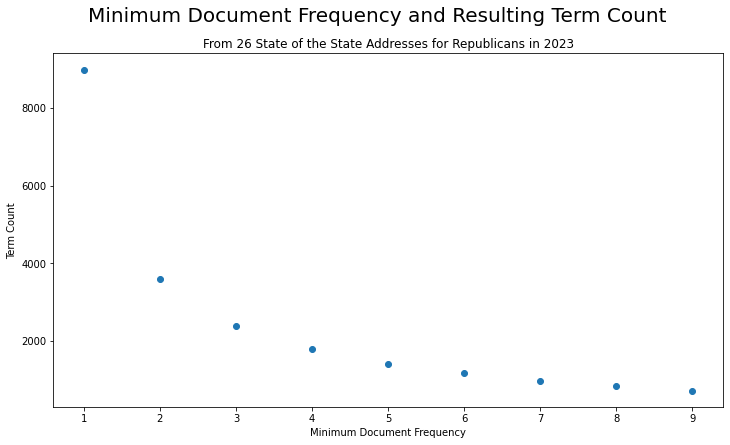

In [162]:
get_min_doc_image(rep, 'Republicans')

##### PCA - Republicans

In [170]:
# not very meaningful or interpretable 
print_pca(rep, 4)

First 5 PC explain 0.2764 of variance in full dataset
First 10 PC explain 0.4968 of variance in full dataset


("PC1: 0.0674 -- ['energy', 'fire', 'power', 'meant', 'enact', 'carbon', 'security', 'innovation', 'produced', 'industries', 'advanced', 'oil', 'mandates', 'land', 'principles', 'fear', 'inflation', 'die', 'national security', 'mind']",
 '',
 "PC2: 0.0575 -- ['energy', 'carbon', 'industries', 'oil', 'innovation', 'advanced', 'security', 'financial', 'agriculture', 'federal', 'winter', 'youth', 'resiliency', 'private', 'markets', 'areas', 'industry', 'proposed', 'grit', 'federal government']",
 '',
 "PC3: 0.0535 -- ['property', 'property tax', 'property taxes', 'relief', 'taxes', 'recommending', 'tax relief', 'percent', 'kids', 'cuts', 'fentanyl', 'tax cuts', 'border', 'michael', 'investments', 'investment', 'local', 'dollar', 'school districts', 'districts']",
 '',
 "PC4: 0.0499 -- ['grid', 'fire', 'border', 'criminals', 'general', 'strong', 'pioneers', 'illegal', 'general assembly', 'schools', 'owners', 'assembly', 'generation', 'pathways', 'hardworking', 'deserve', 'order', 'public s

#### Democrats

In [172]:
# use dtf4 - most interpretable from full ds
dem_dtm4 = tfidf_vectorizer4.fit_transform(dem.text)
dem_dtm4.shape # (24, 1204)

(24, 1204)

In [174]:
dem_top_terms = get_top_terms(dem_dtm4, tfidf_vectorizer4, 20)  
dem_top_terms
dem_df4 = convert_to_term_df(dem_dtm4, tfidf_vectorizer4)
dem_df4.head() 

array(['housing', 'water', 'funding', 'investments', 'workforce',
       'mental', 'nation', 'services', 'kids', 'program', 'legislature',
       'costs', 'county', 'billion', 'access', 'sure', 'system',
       'mental health', 'crisis', 'climate'], dtype=object)

,ability,able,abortion,access,accessible,accomplish,accomplished,achieve,across country,act,...,worth,years ago,years ahead,years come,yet,young,young people,youth,zero,zoning
0,0.000000,0.000000,0.019616,0.023737,0.000000,0.00000,0.0,0.026891,0.000000,0.080672,...,0.000000,0.000000,0.044110,0.022055,0.000000,0.014660,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.042586,0.051531,0.000000,0.04788,0.0,0.000000,0.042586,0.029189,...,0.000000,0.058378,0.000000,0.000000,0.076718,0.000000,0.000000,0.000000,0.000000,0.047880
2,0.021247,0.008489,0.000000,0.067444,0.000000,0.00000,0.0,0.008489,0.000000,0.050937,...,0.013108,0.016979,0.013926,0.000000,0.011157,0.009256,0.000000,0.011740,0.027851,0.013926
3,0.000000,0.000000,0.000000,0.024620,0.040693,0.00000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.055783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.020050,0.016022,0.000000,0.028286,0.000000,0.00000,0.0,0.016022,0.000000,0.000000,...,0.000000,0.048067,0.026282,0.000000,0.000000,0.034939,0.022158,0.022158,0.000000,0.000000


##### Hyperparameter Tuning

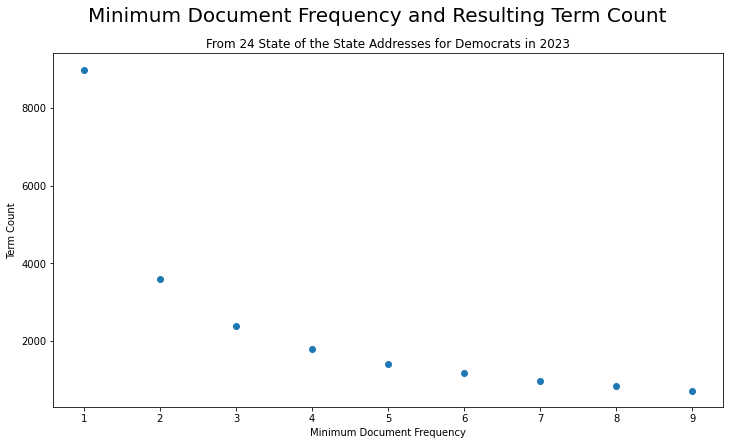

In [180]:
get_min_doc_image(dem, 'Democrats')

##### PCA - Dem

In [183]:
print_pca(dem, 4) # not very interpretative 

First 5 PC explain 0.2951 of variance in full dataset
First 10 PC explain 0.5295 of variance in full dataset


("PC1: 0.0697 -- ['housing', 'idea', 'homelessness', 'crisis', 'legislature', 'hope', 'listen', 'democracy', 'climate', 'housing crisis', 'things', 'rights', 'actions', 'homeless', 'values', 'within', 'red', 'father', 'sell', 'housing homelessness']",
 '',
 "PC2: 0.065 -- ['love', 'easier', 'trying', 'nation', 'world', 'banning', 'else', 'vote', 'anyone', 'something', 'teachers', 'rights', 'story', 'politicians', 'lot', 'river', 'journey', 'second', 'looking', 'father']",
 '',
 "PC3: 0.0552 -- ['kids', 'safety', 'gun', 'easier', 'child care', 'mental', 'public safety', 'clean', 'services', 'guns', 'mental health', 'clean energy', 'anyone', 'access', 'program', 'nation', 'assistance', 'system', 'talk', 'else']",
 '',
 "PC4: 0.0538 -- ['fiscal', 'taxpayers', 'growth', 'less', 'starting', 'senator', 'costs', 'worry', 'control', 'labor', 'covid', 'citizen', 'rescue', 'party', 'economic growth', 'election', 'assistance', 'hit', 'gun', 'tell']",
 '',
 "PC5: 0.0515 -- ['took', 'hope', 'insura

#### Compare Top Terms

In [175]:
print('BOTH')
[i for i in dem_top_terms if i in rep_top_terms]

BOTH


['workforce', 'kids', 'program', 'legislature', 'system']

In [178]:
print('DEMOCRATS')
[i for i in dem_top_terms if i not in rep_top_terms]

DEMOCRATS


['housing',
 'water',
 'funding',
 'investments',
 'mental',
 'nation',
 'services',
 'costs',
 'county',
 'billion',
 'access',
 'sure',
 'mental health',
 'crisis',
 'climate']

In [179]:
print('REPUBLICANS')
[i for i in rep_top_terms if i not in dem_top_terms] 

REPUBLICANS


['schools',
 'energy',
 'teachers',
 'investment',
 'general',
 'needs',
 'percent',
 'property',
 'taxes',
 'session',
 'teacher',
 'fund',
 'community',
 'may',
 'made']

#### PCA

## Regex  - Key Word Exploration

In [184]:
guns = sos[sos['text'].str.contains('gun')]
guns

,state,gov_name,party,type,text,word_count,new_word_count
4,california,gavin newsom,democratic,inaug,Watch Governor Newsom’s swearing-in and inaugu...,2456,2456
5,colorado,jared polis,democratic,sos,ForMedia-2023-StateOfState-GovernorPolis-AsPre...,7859,7859
7,delaware,john carney,democratic,sos,"January 19, 2023 As prepared for delivery #DE...",4157,4157
10,hawaii,josh green,democratic,sos,1 of 17 1 of 17 “ACTION ROOTED IN VALUES”...,5374,5374
19,maryland,wes moore,democratic,sos,"ANNAPOLIS, MD— Today, Governor Wes Moore deli...",4005,4005
21,michigan,gretchen whitmer,democratic,sos,"FOR IMMEDIATE RELEASE January 25, 2023 Cont...",4228,4228
22,minnesota,tim walz,democratic,sos,Governor Walz State of the State Remarks as Pr...,2795,2795
26,nebraska,jim pillen,republican,sos,Governor Jim Pillen ...,3158,3158
29,new jersey,phil murphy,democratic,sos,Governor Murphy Delivers 2023 State of the Sta...,5926,5926
30,new mexico,michelle lujan grisham,democratic,sos,FROM THE OFFICE OF THE GOVERNOR Editor’s note:...,4422,4422


In [121]:
len(sos[sos['text'].str.contains('data')])
sos[sos['text'].str.contains('data')]
sos[sos['text'].str.contains('digital')]

16

,state,gov_name,party,type,text,word_count,new_word_count,digital_regex,climate_regex
1,alaska,mike dunleavy,republican,sos,Governor Dunleavy’s 2023 State of the State Ad...,6469,6469,1,1
8,florida,ron desantis,republican,sos,"From the Space Coast to the Suncoast, from St....",1658,1658,1,1
12,illinois,jb pritzker,democratic,sos,"Gov. Pritzker Proposes Transformative, Gener...",18781,6290,1,1
13,indiana,eric holcomb,republican,sos,Governor Eric J. Holcomb2023 State of the Stat...,2919,2919,1,1
15,kansas,laura kelly,democratic,sos,Governor Kelly Delivers Her 2023 State of the ...,4494,4494,1,1
18,maine,janet mills,democratic,inaug,1 Governor Janet T. Mills Second Inaugural Ad...,3737,3737,1,1
28,new hampshire,chris sununu,republican,inaug,"Concord, NH – Please find below Governor Chris...",3348,3348,1,0
29,new jersey,phil murphy,democratic,sos,Governor Murphy Delivers 2023 State of the Sta...,5926,5926,1,1
30,new mexico,michelle lujan grisham,democratic,sos,FROM THE OFFICE OF THE GOVERNOR Editor’s note:...,4422,4422,1,1
34,ohio,mike dewine,republican,sos,"(COLUMBUS, Ohio)—Ohio Governor Mike DeWine tod...",5670,5670,1,1


,state,gov_name,party,type,text,word_count,new_word_count,digital_regex,climate_regex
17,louisiana,john bel edwards,democratic,sos,"As prepared for delivery: Mr. Speaker, Mr. Pre...",3996,3996,1,1
34,ohio,mike dewine,republican,sos,"(COLUMBUS, Ohio)—Ohio Governor Mike DeWine tod...",5670,5670,1,1


### Digital 

In [114]:
digital_terms = ['data', 'digital', 'technology']

In [115]:
def search_for_terms(text, search_terms):
    result = 0
    for term in search_terms:
        if re.search(term, text, re.IGNORECASE):
            result = 1 
            break       
    return result

In [116]:
sos['digital_regex'] = [search_for_terms(i, digital_terms) for i in sos.text]

In [117]:
data_y = sos[sos.digital_regex == 1]

In [118]:
data_y.shape[0]

32

In [119]:
def extract_sentences_with_context(text, terms):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    relevant_comments = []
    for i, sentence in enumerate(sentences):
        for term in terms:
            if term.lower() in sentence.lower():
                start_index = max(0, i - 2)
                end_index = min(len(sentences), i + 3)
                relevant_sentences = sentences[start_index:end_index]
                relevant_comment = ' '.join(relevant_sentences)
                relevant_comments.append(relevant_comment)
                break
    return relevant_comments

In [123]:
data_y['digital_comments'] = [extract_sentences_with_context(i, digital_terms) for i in data_y.text]

/var/folders/5_/9k6tj5157bx2n0nwswpfzhhw0000gn/T/ipykernel_45190/2319154711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_y['digital_comments'] = [extract_sentences_with_context(i, digital_terms) for i in data_y.text]


In [124]:
data_y.state.values

array(['alabama', 'alaska', 'colorado', 'delaware', 'florida', 'hawaii',
       'illinois', 'indiana', 'kansas', 'louisiana', 'maine', 'maryland',
       'massachusetts', 'michigan', 'mississippi', 'montana', 'nevada',
       'new hampshire', 'new jersey', 'new mexico', 'new york',
       'north carolina', 'north dakota', 'ohio', 'oklahoma',
       'south carolina', 'south dakota', 'tennessee', 'utah', 'vermont',
       'virginia', 'washington'], dtype=object)

In [125]:
for index, row in data_y.iterrows():
    print(row['state'].upper())
    print(row['digital_comments'], '\n')

ALABAMA
['That must begin with improving the school choice we already have: Our charter school options and the Alabama Accountability Act. I am proposing we provide startup funds for Charter Schools and make needed reforms to the governance of the Charter School Commission in order to create better accountability.  Page 6 of 8   These actions will allow more charter schools to form and to ensure high quality education and ultimately…create more choices for parents!  Alabama also continues to support destination magnet schools including the Alabama School of Cyber Technology and Engineering, the Alabama School of Fine Arts and the Alabama School of Math and Science. All are excellent options, and they are most certainly a part of what school choice means in Alabama.   In order for Alabama to be innovative tomorrow, we must be innovative in how we teach our students to learn today.', '  In order for Alabama to be innovative tomorrow, we must be innovative in how we teach our students to 

### Climate

In [131]:
climate_terms = ['climate']

In [185]:
weather_terms = ['flood', 'fire', 'hurricane','earthquake', 'tornado', 'weather', 'blizzard', 'drought', 'wildfire']

In [186]:
sos['weather_regex'] = [search_for_terms(i, weather_terms) for i in sos.text]

In [178]:
sos['climate_regex'] = [search_for_terms(i, climate_terms) for i in sos.text]

In [179]:
climate_y = sos[sos.climate_regex == 1]
climate_y.shape
climate = climate_y.state.values

(23, 10)

In [187]:
weather_y = sos[sos.weather_regex == 1]
weather_y.shape
weather = weather_y.state.values

(36, 10)

In [188]:
climate_only = [i for i in climate_y.state.values if i not in weather_y.state.values]
print('climate only: ' + str(len(climate_only)) + " " + str(climate_only) + '\n')

weather_only = [i for i in weather_y.state.values if i not in climate_y.state.values]
print('weather only: ' + str(len(weather_only)) + " " + str(weather_only)+ '\n')

both = [i for i in climate_y.state.values if i in weather_y.state.values]
print('Both: ' + str(len(both)) + " " + str(both) + '\n')

climate only: 9 ['alabama', 'delaware', 'hawaii', 'maryland', 'massachusetts', 'new york', 'rhode island', 'washington', 'wyoming']

weather only: 22 ['alaska', 'arizona', 'arkansas', 'california', 'florida', 'georgia', 'illinois', 'iowa', 'kansas', 'kentucky', 'mississippi', 'montana', 'nebraska', 'nevada', 'north dakota', 'ohio', 'oklahoma', 'pennsylvania', 'south carolina', 'tennessee', 'texas', 'west virginia']

Both: 14 ['colorado', 'idaho', 'indiana', 'louisiana', 'maine', 'michigan', 'new jersey', 'new mexico', 'north carolina', 'south dakota', 'utah', 'vermont', 'virginia', 'wisconsin']



In [192]:
climate_y['climate_comments'] = [extract_sentences_with_context(i, climate_terms) for i in climate_y.text] 
weather_y['weather_comments'] = [extract_sentences_with_context(i, weather_terms) for i in weather_y.text] 

/var/folders/5_/9k6tj5157bx2n0nwswpfzhhw0000gn/T/ipykernel_45190/4027931946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate_y['climate_comments'] = [extract_sentences_with_context(i, climate_terms) for i in climate_y.text]
/var/folders/5_/9k6tj5157bx2n0nwswpfzhhw0000gn/T/ipykernel_45190/4027931946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_y['weather_comments'] = [extract_sentences_with_context(i, weather_terms) for i in weather_y.text]


In [ ]:
# export for manual review and validation 
climate_y.to_

In [189]:
for index, row in climate_y.iterrows():
    print(row['state'].upper())
    print(row['climate_comments'], '\n')

ALABAMA
['Members…I urge you to completely pay off the Alabama Trust Fund this year. That was the promise made to the people of Alabama, and we should make it a priority. Unlike D.C., we pay our debts!  Alabama’s financial footing compared to other states across the country is solid, and on top of that, Alabama has one of the lowest overall tax burdens in the nation and one of best business climates.  I urge each of you – especially our new members – to continue being wise and responsible with our people’s hard-earned money.   We are, once again, tasked with allocating our taxpayers’ dollars that are part of the second round of the American Rescue Plan Act from Congress.', 'Page 3 of 8    That is why I am calling on you to put nearly a billion dollars back into the hands of hardworking, taxpaying Alabamians through one-time rebates of $400. That means $800 for our working families, and it couldn’t come at a better time!  Folks, this is the people’s money, and it’s only right, while sti

In [193]:
for index, row in weather_y.iterrows():
    print(row['state'].upper())
    print(row['weather_comments'], '\n')

ALASKA
[' Thank you, Heidi, for working so hard to change Alaska for the better.  Alaskans are a people that show their poise under pressure.  Over the past four years, we’ve overcome a historic earthquake, wildfires, landslides, and yes, a once-in-a-century pandemic. Nearly everything has been thrown at us but locusts.  Just this past September, hundreds of miles of our Western coasts and dozens of our communities were inundated with a powerful storm surge that upended homes, roads, boats, vehicles, and fish camps.', ' Together, homes were reset and repaired, and roads and seawalls were rebuilt.   As I traveled the region to monitor the recovery efforts, I met people who embody the toughness, the tenacity, and the leadership that became familiar to me when I lived and worked in rural Alaska.  One of our stops was in the town of Stebbins after the weather cleared enough for us to land.  We’d heard the town’s seawall had been damaged, and I wanted to see what kind of assistance we could